In [1]:
import pickle as pk
import tensorflow as tf
import numpy as np
import tensorflow as tf
from tensorflow.keras import regularizers

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

import os, sys, pathlib, h5py, time

from models import make_model

from astropy.nddata import block_reduce
from astropy.io import fits

from matplotlib import pyplot as plt


%load_ext autoreload
%autoreload 2

%matplotlib inline

2023-01-13 15:50:00.680803: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31016 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0004:04:00.0, compute capability: 7.0
2023-01-13 15:50:00.693387: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31016 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0004:05:00.0, compute capability: 7.0
2023-01-13 15:50:00.695788: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 31016 MB memory:  -> device: 2, name: Tesla V100-SXM2-32GB, pci bus id: 0035:03:00.0, compute capability: 7.0
2023-01-13 15:50:00.698198: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 31016 MB memory:  -> device: 3, name: Tesla V100-SXM2-32GB, pci bus id

This code implements a convolutional neural network (CNN) which classifies images as either being an image of a galaxy cluster or not. The CNN is coded using the tensorflow backend, which is a common package for doing various machine learning tasks. The tensorflow tutorials are an excellent introduction to the framework and can be found here: https://www.tensorflow.org/tutorials/quickstart/beginner. 
In general, TF is a very well supported package, with tons of documentation available online. 

While this code can classify an image as either being of a cluster or not, it cannot identify clusters in an image. By that I mean, given a relatively small image, this code will tell you if that image is of a cluster. If you give it a larger image, however, it can't locate clusters within that image. This is our ultimate goal: a ML algorithm capable of doing cluster detection, at least for ACT data and ideally for ACT+Optical+X-ray images. This is however a good first start: a CNN generally forms the backbone for image segmentation/object detection algorithms. I think for our first cluster detector, we'll want to use a simpler CNN than what's developed in this notebook, it's still a good idea to work through this to get some idea of how CNN's work, both conceptually and in code.

For this notebook, the images we are using to train the model and which ultimately we hope to classify have six channels (ML term) or bands (astro term): 5 DES bands (GRIzY) and 1 ACT compton-y. The project we're going to be working on is going to instead use the 3 ACT frequency channels (90, 150, 200) and an off-the-shelf CNN, but again reading through this all is a good exercise. 

# Load and perform some cuts on data

In [22]:
data_dir = '/project/r/rbond/jorlo/datasets/ml-clusters/for-debug/'

#Toggles whether compton-y data is included. When including compton-y data, the CNN basically only uses that to
#distinguish clusters from non-clusters. It does work the optical data only, but you have to turn off the compton-y
#channel to force it to use optical
w_y = 'False'

#Controls how many clusters we load, 1000 is fine for debugging, learning how the notebook works, etc
cut = 1000

In [23]:
pos_im_act = []
pos_im_des = []
neg_im = []

#I made images centered on ACT and DES cluster locations (positives) as well as random points at least 5' 
#from a known cluster (negatives). This code just loads those
for directory in os.listdir(data_dir):
    print(directory)
    if directory[:3] == 'act' and (int(directory[4:8]) < cut):
        h5f = h5py.File(data_dir+directory)
        pos_im_act.append(h5f['act'][:])
    elif directory[:3] == 'des' and (int(directory[4:8]) < cut):
        h5f = h5py.File(data_dir+directory)
        pos_im_des.append(h5f['des'][:])
    elif directory[:6]=='random' and (int(directory[7:11]) < cut):
        h5f = h5py.File(data_dir+directory)
        neg_im.append(h5f['random'][:])


#stacks everything into one big positive image array and one big negative image array
pos_im_act = np.vstack(pos_im_act)
pos_im_des = np.vstack(pos_im_des)
neg_im = np.vstack(neg_im)


pos_im = np.concatenate((pos_im_act, pos_im_des))


#cuts out any maps that have nans in them
flags = []
for i in range(pos_im.shape[0]):
        if np.any(np.isnan(pos_im[i,...])):
                flags.append(i)

pos_im = np.delete(pos_im, flags, axis = 0)

flags = []
for i in range(neg_im.shape[0]):
        if np.any(np.isnan(neg_im[i,...])):
                flags.append(i)

neg_im = np.delete(neg_im, flags, axis = 0)


#Force the positive and negative samples to have the same size
neg_im = neg_im[:len(pos_im)]
pos_im = pos_im[:len(neg_im)]

print(len(pos_im), len(neg_im))

save_neg_im = neg_im
save_pos_im = pos_im

random_2000_w_y.h5
des_5000_w_y.h5
des_2000_w_y.h5
random_0000_w_y.h5
des_0000_w_y.h5
des_1000_w_y.h5
random_6000_w_y.h5
random_7000_w_y.h5
random_5000_w_y.h5
des_6000_w_y.h5
act_1000_w_y.h5
random_4000_w_y.h5
random_3000_w_y.h5
act_3000_w_y.h5
des_4000_w_y.h5
random_1000_w_y.h5
act_0000_w_y.h5
des_3000_w_y.h5
922 922


In [24]:

#Allows us to block reduce the images, which reduces their resolution by reducing blocks of a size [reduce, reduce] to one pixel
#using a specified function, in this case the average (i.e., np.mean)
reduce = False

if reduce:
    neg_im_2 = []
    pos_im_2 = []

    for i in range(len(neg_im)):
        neg_im_2.append(block_reduce(save_neg_im[i], [reduce,reduce,1], func = np.mean))
        pos_im_2.append(block_reduce(save_pos_im[i], [reduce,reduce,1], func = np.mean))
        

    pos_im = np.array(pos_im_2)
    neg_im = np.array(neg_im_2)


In [25]:
#Allows us to further cut the sample sizes if we want

cut_2 = 10
if cut_2:
    neg_im = neg_im[:cut_2]
    pos_im = pos_im[:cut_2]

    
print(neg_im.shape)

(10, 399, 399, 6)


In [26]:
#If we don't want to fit with the compton-y data, drop the last column, which is the y channel
if w_y == 'False':
    pos_im, neg_im = pos_im[...,:5], neg_im[...,:5]

print('Fitting with y = ', w_y)

#Split data into a training (70%), validation (15%), and test (15%) samples. The train data
#will actually train the model, while we will use the validation data set actively during training
#to quantify how well the model does. Test is held fully in reserve and essentially is our blinding:
#we shouldn't check test until the very end
tot = min(pos_im.shape[0], neg_im.shape[0])
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)

train_pos = pos_im[:train_size]
val_pos = pos_im[train_size:train_size + val_size]
test_pos = pos_im[train_size + val_size:]

train_neg = neg_im[:train_size]
val_neg = neg_im[train_size:train_size + val_size]
test_neg = neg_im[train_size + val_size:]

input_shape = train_pos.shape[1:]

train_images = np.concatenate((train_pos,train_neg))
val_images = np.concatenate((val_pos,val_neg))
test_images = np.concatenate((test_pos,test_neg))

train_labels = np.array(train_pos.shape[0]*[1] + train_neg.shape[0]*[0])
val_labels = np.array(val_pos.shape[0]*[1] + val_neg.shape[0]*[0])
test_labels = np.array(test_pos.shape[0]*[1] + test_neg.shape[0]*[0])

#This just sets the # of samples we include in a trianing epoch, which is called the batch size. Autotune is a bit
#of magic that allows tf to dynamically set some hyperparameters in an optimal way. See https://www.tensorflow.org/guide/data_performance
batch_size = 500
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

#We shuffle our data (i.e. just mix up the order) and batch it
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

#Preloads data into memory
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Fitting with y =  False


In [27]:

#A little helper function which makes the actual CNN model. You can look in utils if you're curious about the architechure 
#but you can also just consider this a black box.
model = make_model('test', input_shape = input_shape, kernel_regularizer=regularizers.l2(0.001))

#We perform data augmentation due to our low number of samples. Data augmentation takes our data set, and generates
#additional samples by performing a variety of image transforms, which you can more or less readoff from the arguments
#I've passed to the ImageDataGenerator function
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=4,
    height_shift_range=4,zoom_range=0.3)

#Sets checkpoint paths for the models. This is just where the model is saved at intermediate steps, and allows us
#to reload the model for very long training sessions
if w_y == 'False':
        checkpoint_path = "/scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_wo_y.ckpt"

else:
        checkpoint_path = "/scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_w_y.ckpt"

        
checkpoint_dir = os.path.dirname(checkpoint_path)

#A helper function for checkpointing
def get_callbacks(name):
    return [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1),
      tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100),
      tf.keras.callbacks.TensorBoard(checkpoint_dir+name),
    ]        


# Create a callback that saves the model's weights

name = 'w_y={}'.format(w_y)

toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 
history = model.fit(data_augmentation.flow(train_images, train_labels), epochs=int(50), 
                    validation_data=val_dataset, callbacks=get_callbacks(name))
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 399, 399, 16)      736       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 199, 199, 16)     0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 199, 199, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 199, 199, 32)      4640      
                                                    

/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/keras_preprocessing/image/numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (14, 399, 399, 5) (5 channels).
  warnings.warn('NumpyArrayIterator is set to use the '
2023-01-11 09:49:58.559524: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_56919

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
1/1 [==============================] - ETA: 0s - loss: 2.0566 - accuracy: 0.3571

2023-01-11 09:50:05.448074: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 2
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:2391"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 399
        }
        dim {
          size: 399
        }
        dim {
          size: 5
        }
      }
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO


Epoch 1: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_wo_y.ckpt
1/1 [==============================] - 10s 10s/step - loss: 2.0566 - accuracy: 0.3571 - val_loss: 66.3333 - val_accuracy: 0.5000
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 36.4196 - accuracy: 0.5000
Epoch 2: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_wo_y.ckpt
1/1 [==============================] - 2s 2s/step - loss: 36.4196 - accuracy: 0.5000 - val_loss: 38.3283 - val_accuracy: 0.5000
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 24.0992 - accuracy: 0.5000
Epoch 3: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_wo_y.ckpt
1/1 [==============================] - 2s 2s/step - loss: 24.0992 - accuracy: 0.5000 - val_loss: 27.9639 - val_accuracy: 0.5000
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 14.2072 - accuracy: 0.5000
Epoch 4: saving model to /scratch/r/rbond/jorlo/ml

2023-01-11 09:52:20.391554: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 4
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:2392"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 399
        }
        dim {
          size: 399
        }
        dim {
          size: 5
        }
      }
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO

1/1 - 0s - loss: 2.1578 - accuracy: 0.5000 - 468ms/epoch - 468ms/step


In [10]:
#Same as above, just using a slightly different architechture for the CNN. One thing both Dimitrios and I have found is that
#frankly the architecture doesn't make a huge difference as long as you're doing something reasonable. Prepping the data
#is much more important. DES only fitting does not work at all without data augmentation

model = make_model('test-no-dist', input_shape = input_shape, kernel_regularizer=regularizers.l2(0.001))


data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=4,
    height_shift_range=4,zoom_range=0.3)

if w_y == 'False':
        checkpoint_path = "/scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_wo_y.ckpt"

else:
        checkpoint_path = "/scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_w_y.ckpt"

        
checkpoint_dir = os.path.dirname(checkpoint_path)

def get_callbacks(name):
    return [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1),
      tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100),
      tf.keras.callbacks.TensorBoard(checkpoint_dir+name),
    ]        


# Create a callback that saves the model's weights

name = 'w_y={}'.format(w_y)

toc = time.time()
history = model.fit(data_augmentation.flow(train_images, train_labels), epochs=int(100), 
                    validation_data=val_dataset, callbacks=get_callbacks(name))
tic = time.time()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 49, 49, 16)        880       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 32)        4640      
                                                    

44/44 [==============================] - 2s 52ms/step - loss: 0.1266 - accuracy: 0.9671 - val_loss: 0.1307 - val_accuracy: 0.9633
Epoch 45/100
43/44 [============================>.] - ETA: 0s - loss: 0.1072 - accuracy: 0.9759
Epoch 45: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_w_y.ckpt
44/44 [==============================] - 2s 50ms/step - loss: 0.1058 - accuracy: 0.9764 - val_loss: 0.1447 - val_accuracy: 0.9667
Epoch 46/100
44/44 [==============================] - ETA: 0s - loss: 0.1160 - accuracy: 0.9686
Epoch 46: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_w_y.ckpt
44/44 [==============================] - 2s 54ms/step - loss: 0.1160 - accuracy: 0.9686 - val_loss: 0.1623 - val_accuracy: 0.9567
Epoch 47/100
44/44 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9764
Epoch 47: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_w_y.ckpt
44/44 [==============================

44/44 [==============================] - 2s 48ms/step - loss: 0.1007 - accuracy: 0.9736 - val_loss: 0.1165 - val_accuracy: 0.9633
Epoch 96/100
43/44 [============================>.] - ETA: 0s - loss: 0.0941 - accuracy: 0.9759
Epoch 96: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_w_y.ckpt
44/44 [==============================] - 2s 48ms/step - loss: 0.0926 - accuracy: 0.9764 - val_loss: 0.1880 - val_accuracy: 0.9467
Epoch 97/100
43/44 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.9708
Epoch 97: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_w_y.ckpt
44/44 [==============================] - 2s 50ms/step - loss: 0.0975 - accuracy: 0.9714 - val_loss: 0.0930 - val_accuracy: 0.9800
Epoch 98/100
44/44 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 0.9700
Epoch 98: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_w_y.ckpt
44/44 [==============================

In [11]:
print('Undistributed time: ', tic-toc)


Undistributed time:  247.986478805542


In [23]:
#This is a little test I did where I take the with-y model and zero out all the weights having to do with the compton-y channel
#Essentially I'm asking if the model has learned anything about the optical: the answer is a bit

test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

print('\nTest accuracy: ', test_acc)

#Turn off Y info

if w_y == 'True':
    no_y_model = make_model('test', input_shape = input_shape)
    
    checkpoint_path = "/scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_w_y.ckpt"


    no_y_model.load_weights(checkpoint_path)

    #I think this is zeroing everything but y?
    for layer in no_y_model.layers:
        if layer.name[0:6] == 'conv2d':
            temp = layer.get_weights()
            #temp[0][...,-1:,:] = np.zeros(temp[0][...,-1:,:].shape)
            layer.set_weights(temp)
            for j in range(temp.shape[-1]):
                plt.imshow(temp[...:j])
                plt.show()
                plt.close()

    test_loss, test_acc = no_y_model.evaluate(test_dataset, verbose=2)

    print('\nNo y test accuracy: ', test_acc)
        

1/1 - 0s - loss: 0.4790 - accuracy: 0.7933 - 53ms/epoch - 53ms/step

Test accuracy:  0.7933333516120911


In [ ]:
show_compressed = True

for i in range(5):
    print(i)
    if show_compressed:
        if w_y == 'True':
            plt.imshow(neg_im[i,...,5])
            plt.title('Negative in y')
            plt.show()
            plt.close()


        plt.imshow(np.log(np.abs(neg_im[i,...,1])))
        plt.title('Negative in Optical, r band')
        plt.show()
        plt.close()


        if w_y == 'True':
            plt.imshow(pos_im[i,...,5])
            plt.title('Positive in y')
            plt.show()
            plt.close()


        plt.imshow(np.log(np.abs(pos_im[i,...,1])))
        plt.title('Positive in Optical, r band')
        plt.show()
        plt.close()

    else:
        if w_y == 'True':
            plt.imshow(save_neg_im[i,...,5])
            plt.title('Negative in y')
            plt.show()
            plt.close()


        plt.imshow(np.log(np.abs(save_neg_im[i,...,1])))
        plt.title('Negative in Optical, r band')
        plt.show()
        plt.close()


        if w_y == 'True':
            plt.imshow(save_pos_im[i,...,5])
            plt.title('Positive in y')
            plt.show()
            plt.close()


        plt.imshow(np.log(np.abs(save_pos_im[i,...,1])))
        plt.title('Positive in Optical, r band')
        plt.show()
        plt.close()


In [ ]:
#View Model weights

labels = ['g','r','i','z','y','comptony']

for layer in model.layers:
    if layer.name[0:6] == 'conv2d':
        temp = layer.get_weights()
        print('Layer: ',layer.name)
        print(temp[0].shape)
        for j in range(temp[0].shape[-1]):
            print('Filter: ',j)
            for k in range(temp[0][...,j].shape[-1]):
                print('Band: ', labels[k])
                plt.imshow(temp[0][...,j][...,k], vmin = np.amin(temp[0]), vmax = np.amax(temp[0]))
                plt.colorbar()
                plt.show()
                plt.close()

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)


In [ ]:
model = make_model('test',  input_shape = input_shape)

checkpoint_path = "/scratch/r/rbond/jorlo/ml-clusters/models/redmapper_wo_y.ckpt"
model.load_weights(checkpoint_path)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)


# Hyperparameters

In [16]:
#Don't worry about what's going on down here yet

tuner = make_model('test_hyper')

In [17]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)

tuner.search(train_images, train_labels, epochs=200, validation_data=val_dataset, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('dropout1')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


Trial 100 Complete [00h 00m 09s]
val_accuracy: 0.9766666889190674

Best val_accuracy So Far: 0.996666669845581
Total elapsed time: 00h 23m 47s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 0.5 and the optimal learning rate for the optimizer
is 0.0001.



In [18]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_images, train_labels, epochs=50, validation_data=val_dataset)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
44/44 [==============================] - 1s 10ms/step - loss: 0.3276 - accuracy: 0.8471 - val_loss: 0.1702 - val_accuracy: 0.9233
Epoch 2/50
44/44 [==============================] - 0s 7ms/step - loss: 0.0960 - accuracy: 0.9593 - val_loss: 0.1301 - val_accuracy: 0.9500
Epoch 3/50
44/44 [==============================] - 0s 7ms/step - loss: 0.0714 - accuracy: 0.9736 - val_loss: 0.1108 - val_accuracy: 0.9567
Epoch 4/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0670 - accuracy: 0.9779 - val_loss: 0.0629 - val_accuracy: 0.9733
Epoch 5/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0696 - accuracy: 0.9736 - val_loss: 0.0668 - val_accuracy: 0.9733
Epoch 6/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0520 - accuracy: 0.9850 - val_loss: 0.0583 - val_accuracy: 0.9833
Epoch 7/50
44/44 [==============================] - 0s 7ms/step - loss: 0.0532 - accuracy: 0.9821 - val_loss: 0.0548 - val_accuracy: 0.9733
Epoch 8/50
44/44 [=

In [19]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_images, train_labels, epochs=best_epoch, validation_data=val_dataset)

Epoch 1/25
44/44 [==============================] - 1s 10ms/step - loss: 0.2724 - accuracy: 0.8914 - val_loss: 0.1415 - val_accuracy: 0.9367
Epoch 2/25
44/44 [==============================] - 0s 6ms/step - loss: 0.0831 - accuracy: 0.9693 - val_loss: 0.1430 - val_accuracy: 0.9467
Epoch 3/25
44/44 [==============================] - 0s 6ms/step - loss: 0.0714 - accuracy: 0.9721 - val_loss: 0.0984 - val_accuracy: 0.9667
Epoch 4/25
44/44 [==============================] - 0s 7ms/step - loss: 0.0645 - accuracy: 0.9750 - val_loss: 0.0879 - val_accuracy: 0.9667
Epoch 5/25
44/44 [==============================] - 0s 6ms/step - loss: 0.0588 - accuracy: 0.9807 - val_loss: 0.0537 - val_accuracy: 0.9800
Epoch 6/25
44/44 [==============================] - 0s 6ms/step - loss: 0.0561 - accuracy: 0.9821 - val_loss: 0.0527 - val_accuracy: 0.9833
Epoch 7/25
44/44 [==============================] - 0s 7ms/step - loss: 0.0528 - accuracy: 0.9843 - val_loss: 0.0567 - val_accuracy: 0.9800
Epoch 8/25
44/44 [=

In [21]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

print('\nTest accuracy: ', test_acc)

#Turn off Y info

if w_y == 'True':
    no_y_model = make_model('test', input_shape = input_shape)
    
    checkpoint_path = "/scratch/r/rbond/jorlo/ml-clusters/results/hyper_parameters/jupyter_redmapper_w_y.ckpt"


    no_y_model.load_weights(checkpoint_path)

    #I think this is zeroing everything but y?
    for layer in no_y_model.layers:
        if layer.name[0:6] == 'conv2d':
            temp = layer.get_weights()
            #temp[0][...,-1:,:] = np.zeros(temp[0][...,-1:,:].shape)
            layer.set_weights(temp)
            for j in range(temp.shape[-1]):
                plt.imshow(temp[...:j])
                plt.show()
                plt.close()

    test_loss, test_acc = no_y_model.evaluate(test_dataset, verbose=2)

    print('\nNo y test accuracy: ', test_acc)
        

1/1 - 0s - loss: 0.0641 - accuracy: 0.9867 - 59ms/epoch - 59ms/step

Test accuracy:  0.9866666793823242
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 49, 49, 16)        880       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 16)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 16)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                

ValueError: Shapes (2304, 512) and (36864, 512) are incompatible

# RESNet

In [8]:
from keras_frcnn import resnet as nn
from keras_frcnn import config
from keras.layers import Input
from keras.models import Model

from keras_frcnn import losses as losses

import keras



In [9]:
C = config.Config()

C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

C.model_path = '/scratch/r/rbond/jorlo/ml-clusters/models/weights/model_frcnn.hdf5'
C.num_rois = int(32)

C.network = 'resnet50'

C.base_net_weights = nn.get_weight_path()

classes_count = {'bg':len(neg_im), 'cluster':len(pos_im)}

In [27]:
img_input = Input(shape = (None, None, input_shape[-1]))
roi_input = Input(shape=(None, 4))

shared_layers = nn.nn_base(img_input, trainable=True)

num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn = nn.rpn(shared_layers, num_anchors)
# detection network 정의
classifier = nn.classifier(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count), trainable=True)

model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)
#model_classifier = Model(img_input, classifier)

# this is a model that holds both the RPN and the classifier, used to load/save weights for the models
model_all = Model([img_input, roi_input], rpn[:2] + classifier)

optimizer =  keras.optimizers.adam_v2.Adam(learning_rate = 1e-5)#Adam(lr=1e-5)
optimizer_classifier =   keras.optimizers.adam_v2.Adam(learning_rate = 1e-5)#Adam(lr=1e-5)

model_rpn.compile(optimizer=optimizer, loss=[losses.rpn_loss_cls(num_anchors), losses.rpn_loss_regr(num_anchors)])
model_classifier.compile(optimizer=optimizer_classifier, loss=[losses.class_loss_cls, losses.class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
model_all.compile(optimizer='sgd', loss='mae')

model_shared = Model(img_input, shared_layers)

input shape:  (None, None, 6)


In [28]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model_shared.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model_shared.fit(
    train_dataset, epochs=epochs, callbacks=callbacks, validation_data=val_dataset,
)

Epoch 1/50


2022-08-26 10:26:40.790309: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: required broadcastable shapes
2022-08-26 10:26:40.790447: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: required broadcastable shapes
2022-08-26 10:26:40.790475: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError: Graph execution error:

Detected at node 'Equal' defined at (most recent call last):
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1955072/3190096676.py", line 11, in <cell line: 11>
      model_shared.fit(
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/keras/engine/training.py", line 864, in train_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/keras/engine/training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/keras/metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/keras/metrics.py", line 729, in update_state
      matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/keras/metrics.py", line 4086, in sparse_categorical_accuracy
      return tf.cast(tf.equal(y_true, y_pred), backend.floatx())
Node: 'Equal'
required broadcastable shapes
	 [[{{node Equal}}]] [Op:__inference_train_function_103109]

In [29]:
model_shared.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, None, None,  0           []                               
                                 6)]                                                              
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, None, None,   0          ['input_13[0][0]']               
 D)                             6)                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   18880       ['zero_padding2d_6[0][0]']       
                                64)                                                        

                                                                                                  
 activation_300 (Activation)    (None, None, None,   0           ['add_97[0][0]']                 
                                256)                                                              
                                                                                                  
 res2c_branch2a (Conv2D)        (None, None, None,   16448       ['activation_300[0][0]']         
                                64)                                                               
                                                                                                  
 bn2c_branch2a (FixedBatchNorma  (None, None, None,   256        ['res2c_branch2a[0][0]']         
 lization)                      64)                                                               
                                                                                                  
 activatio

 lization)                      128)                                                              
                                                                                                  
 activation_308 (Activation)    (None, None, None,   0           ['bn3b_branch2b[0][0]']          
                                128)                                                              
                                                                                                  
 res3b_branch2c (Conv2D)        (None, None, None,   66048       ['activation_308[0][0]']         
                                512)                                                              
                                                                                                  
 bn3b_branch2c (FixedBatchNorma  (None, None, None,   2048       ['res3b_branch2c[0][0]']         
 lization)                      512)                                                              
          

 activation_316 (Activation)    (None, None, None,   0           ['bn4a_branch2a[0][0]']          
                                256)                                                              
                                                                                                  
 res4a_branch2b (Conv2D)        (None, None, None,   590080      ['activation_316[0][0]']         
                                256)                                                              
                                                                                                  
 bn4a_branch2b (FixedBatchNorma  (None, None, None,   1024       ['res4a_branch2b[0][0]']         
 lization)                      256)                                                              
                                                                                                  
 activation_317 (Activation)    (None, None, None,   0           ['bn4a_branch2b[0][0]']          
          

                                                                                                  
 add_105 (Add)                  (None, None, None,   0           ['bn4c_branch2c[0][0]',          
                                1024)                             'activation_321[0][0]']         
                                                                                                  
 activation_324 (Activation)    (None, None, None,   0           ['add_105[0][0]']                
                                1024)                                                             
                                                                                                  
 res4d_branch2a (Conv2D)        (None, None, None,   262400      ['activation_324[0][0]']         
                                256)                                                              
                                                                                                  
 bn4d_bran

                                256)                                                              
                                                                                                  
 res4f_branch2c (Conv2D)        (None, None, None,   263168      ['activation_332[0][0]']         
                                1024)                                                             
                                                                                                  
 bn4f_branch2c (FixedBatchNorma  (None, None, None,   4096       ['res4f_branch2c[0][0]']         
 lization)                      1024)                                                             
                                                                                                  
 add_108 (Add)                  (None, None, None,   0           ['bn4f_branch2c[0][0]',          
                                1024)                             'activation_330[0][0]']         
          

# ILC compton y maps

In [15]:

data_dir = '/project/r/rbond/jorlo/datasets/act_y_stamps/'

with np.load(data_dir + 'ilc_all_clusters.npz') as data:
    pos_im = data['arr_0']
with np.load(data_dir + 'ilc_randoms.npz') as data:
    neg_im = data['arr_0']    
#stacks everything into one big positive image array and one big negative image array



#cuts out any maps that have nans in them
flags = []
for i in range(pos_im.shape[0]):
        if np.any(np.isnan(pos_im[i,...])):
                flags.append(i)

pos_im = np.delete(pos_im, flags, axis = 0)

flags = []
for i in range(neg_im.shape[0]):
        if np.any(np.isnan(neg_im[i,...])):
                flags.append(i)

neg_im = np.delete(neg_im, flags, axis = 0)


#Force the positive and negative samples to have the same size
neg_im = neg_im[:len(pos_im)]
pos_im = pos_im[:len(neg_im)]

print(len(pos_im), len(neg_im))

pos_im = np.expand_dims(pos_im, axis=-1)
neg_im = np.expand_dims(neg_im, axis=-1)

pos_im *= 1e5
neg_im *= 1e5

save_neg_im = neg_im
save_pos_im = pos_im

3474 3474


In [16]:
tot = min(pos_im.shape[0], neg_im.shape[0])
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)

train_pos = pos_im[:train_size]
val_pos = pos_im[train_size:train_size + val_size]
test_pos = pos_im[train_size + val_size:]

train_neg = neg_im[:train_size]
val_neg = neg_im[train_size:train_size + val_size]
test_neg = neg_im[train_size + val_size:]

input_shape = train_pos.shape[1:]

train_images = np.concatenate((train_pos,train_neg))
val_images = np.concatenate((val_pos,val_neg))
test_images = np.concatenate((test_pos,test_neg))

train_labels = np.array(train_pos.shape[0]*[1] + train_neg.shape[0]*[0])
val_labels = np.array(val_pos.shape[0]*[1] + val_neg.shape[0]*[0])
test_labels = np.array(test_pos.shape[0]*[1] + test_neg.shape[0]*[0])

#This just sets the # of samples we include in a trianing epoch, which is called the batch size. Autotune is a bit
#of magic that allows tf to dynamically set some hyperparameters in an optimal way. See https://www.tensorflow.org/guide/data_performance
batch_size = 500
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

#We shuffle our data (i.e. just mix up the order) and batch it
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

#Preloads data into memory
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [17]:

model = make_model('test', input_shape = input_shape, kernel_regularizer=regularizers.l2(0.001))

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=4,
    height_shift_range=4,zoom_range=0.3)


checkpoint_path = "/scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_ilc_y.ckpt"

        
checkpoint_dir = os.path.dirname(checkpoint_path)

#A helper function for checkpointing
def get_callbacks(name):
    return [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1),
      tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100),
      tf.keras.callbacks.TensorBoard(checkpoint_dir+name),
    ]        


# Create a callback that saves the model's weights

name = 'ilc_y'

toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 
history = model.fit(data_augmentation.flow(train_images, train_labels), epochs=int(50), 
                    validation_data=val_dataset, callbacks=get_callbacks(name))
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 37, 37, 16)        160       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 18, 18, 16)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 18, 18, 16)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 18, 18, 32)        4640      
                                                    

2022-12-21 13:56:23.617312: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_276124"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:7147"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
 

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
151/152 [============================>.] - ETA: 0s - loss: 0.7110 - accuracy: 0.8675

2022-12-21 13:56:32.956240: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1042
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:7135"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 37
        }
        dim {
          size: 37
        }
        dim {
          size: 1
        }
      }
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR


Epoch 1: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_ilc_y.ckpt
152/152 [==============================] - 11s 32ms/step - loss: 0.7088 - accuracy: 0.8682 - val_loss: 0.4848 - val_accuracy: 0.9107
Epoch 2/50
151/152 [============================>.] - ETA: 0s - loss: 0.4337 - accuracy: 0.9062
Epoch 2: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_ilc_y.ckpt
152/152 [==============================] - 3s 17ms/step - loss: 0.4348 - accuracy: 0.9060 - val_loss: 0.3706 - val_accuracy: 0.9098
Epoch 3/50
152/152 [==============================] - ETA: 0s - loss: 0.3505 - accuracy: 0.9097
Epoch 3: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_ilc_y.ckpt
152/152 [==============================] - 3s 19ms/step - loss: 0.3505 - accuracy: 0.9097 - val_loss: 0.3317 - val_accuracy: 0.9203
Epoch 4/50
149/152 [============================>.] - ETA: 0s - loss: 0.3232 - accuracy: 0.9022
Epoch 4: saving model to /

152/152 [==============================] - 3s 17ms/step - loss: 0.2440 - accuracy: 0.9120 - val_loss: 0.2399 - val_accuracy: 0.9184
Epoch 27/50
149/152 [============================>.] - ETA: 0s - loss: 0.2378 - accuracy: 0.9148
Epoch 27: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_ilc_y.ckpt
152/152 [==============================] - 3s 17ms/step - loss: 0.2394 - accuracy: 0.9140 - val_loss: 0.2377 - val_accuracy: 0.9155
Epoch 28/50
149/152 [============================>.] - ETA: 0s - loss: 0.2385 - accuracy: 0.9140
Epoch 28: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_ilc_y.ckpt
152/152 [==============================] - 3s 17ms/step - loss: 0.2385 - accuracy: 0.9140 - val_loss: 0.2350 - val_accuracy: 0.9127
Epoch 29/50
149/152 [============================>.] - ETA: 0s - loss: 0.2431 - accuracy: 0.9117
Epoch 29: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_ilc_y.ckpt
152/152 [=============

2022-12-21 13:59:01.693388: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1044
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:7136"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 37
        }
        dim {
          size: 37
        }
        dim {
          size: 1
        }
      }
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

3/3 - 0s - loss: 0.1916 - accuracy: 0.9310 - 434ms/epoch - 145ms/step


# Freq Maps

In [15]:
data_dir = '/project/r/rbond/jorlo/datasets/act_freq_stamps/'

with np.load(data_dir + 'all_clusters_offset.npz') as data:
    pos_im = data['arr_0']
with np.load(data_dir + 'randoms.npz') as data:
    neg_im = data['arr_0']    
#stacks everything into one big positive image array and one big negative image array



#cuts out any maps that have nans in them
flags = []
for i in range(pos_im.shape[0]):
        if np.any(np.isnan(pos_im[i,...])):
                flags.append(i)

pos_im = np.delete(pos_im, flags, axis = 0)

flags = []
for i in range(neg_im.shape[0]):
        if np.any(np.isnan(neg_im[i,...])):
                flags.append(i)

neg_im = np.delete(neg_im, flags, axis = 0)


#Force the positive and negative samples to have the same size
neg_im = neg_im[:len(pos_im)]
pos_im = pos_im[:len(neg_im)]

print(len(pos_im), len(neg_im))

pos_im *= 1e-3
neg_im *= 1e-3

save_neg_im = neg_im
save_pos_im = pos_im

4195 4195


In [16]:
tot = min(pos_im.shape[0], neg_im.shape[0])
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)

train_pos = pos_im[:train_size]
val_pos = pos_im[train_size:train_size + val_size]
test_pos = pos_im[train_size + val_size:]

train_neg = neg_im[:train_size]
val_neg = neg_im[train_size:train_size + val_size]
test_neg = neg_im[train_size + val_size:]

input_shape = train_pos.shape[1:]

train_images = np.concatenate((train_pos,train_neg))
val_images = np.concatenate((val_pos,val_neg))
test_images = np.concatenate((test_pos,test_neg))

train_labels = np.array(train_pos.shape[0]*[1] + train_neg.shape[0]*[0])
val_labels = np.array(val_pos.shape[0]*[1] + val_neg.shape[0]*[0])
test_labels = np.array(test_pos.shape[0]*[1] + test_neg.shape[0]*[0])

#This just sets the # of samples we include in a trianing epoch, which is called the batch size. Autotune is a bit
#of magic that allows tf to dynamically set some hyperparameters in an optimal way. See https://www.tensorflow.org/guide/data_performance
batch_size = 500
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

#We shuffle our data (i.e. just mix up the order) and batch it
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(batch_size)

#Preloads data into memory
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [19]:
model = make_model('test', input_shape = input_shape, kernel_regularizer=regularizers.l2(0.001))

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=0.9,
    height_shift_range=0.9,zoom_range=0.3)


checkpoint_path = "/scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_ilc_y.ckpt"

        
checkpoint_dir = os.path.dirname(checkpoint_path)

#A helper function for checkpointing
def get_callbacks(name):
    return [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1),
      tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100),
      tf.keras.callbacks.TensorBoard(checkpoint_dir+name),
    ]        


# Create a callback that saves the model's weights

name = 'ilc_y'

toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 
history = model.fit(data_augmentation.flow(train_images, train_labels), epochs=int(50), 
                    validation_data=val_dataset, callbacks=get_callbacks(name))
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 41, 41, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 20, 20, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 20, 20, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 20, 32)        4640      
                                                    

2023-01-09 11:48:46.071339: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_200249"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:4769"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
 

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 10 all-reduces with algorithm = nccl, num_packs = 1
181/184 [============================>.] - ETA: 0s - loss: 0.6837 - accuracy: 0.7306

2023-01-09 11:48:57.643311: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1258
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:2391"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 41
        }
        dim {
          size: 41
        }
        dim {
          size: 3
        }
      }
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO


Epoch 1: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_ilc_y.ckpt
184/184 [==============================] - 13s 33ms/step - loss: 0.6798 - accuracy: 0.7319 - val_loss: 0.2998 - val_accuracy: 0.9181
Epoch 2/50
184/184 [==============================] - ETA: 0s - loss: 0.4469 - accuracy: 0.8149
Epoch 2: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_ilc_y.ckpt
184/184 [==============================] - 5s 28ms/step - loss: 0.4469 - accuracy: 0.8149 - val_loss: 0.3379 - val_accuracy: 0.8744
Epoch 3/50
183/184 [============================>.] - ETA: 0s - loss: 0.4173 - accuracy: 0.8313
Epoch 3: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_ilc_y.ckpt
184/184 [==============================] - 5s 28ms/step - loss: 0.4174 - accuracy: 0.8314 - val_loss: 0.2565 - val_accuracy: 0.9094
Epoch 4/50
183/184 [============================>.] - ETA: 0s - loss: 0.4187 - accuracy: 0.8332
Epoch 4: saving model to /

184/184 [==============================] - 5s 28ms/step - loss: 0.3435 - accuracy: 0.8643 - val_loss: 0.2123 - val_accuracy: 0.9316
Epoch 27/50
183/184 [============================>.] - ETA: 0s - loss: 0.3595 - accuracy: 0.8613
Epoch 27: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_ilc_y.ckpt
184/184 [==============================] - 5s 28ms/step - loss: 0.3606 - accuracy: 0.8609 - val_loss: 0.1579 - val_accuracy: 0.9610
Epoch 28/50
182/184 [============================>.] - ETA: 0s - loss: 0.3421 - accuracy: 0.8642
Epoch 28: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_ilc_y.ckpt
184/184 [==============================] - 5s 28ms/step - loss: 0.3425 - accuracy: 0.8641 - val_loss: 0.1798 - val_accuracy: 0.9452
Epoch 29/50
183/184 [============================>.] - ETA: 0s - loss: 0.3413 - accuracy: 0.8659
Epoch 29: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_ilc_y.ckpt
184/184 [=============

2023-01-09 11:53:32.654197: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_INT64
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1260
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\027TensorSliceDataset:2392"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 41
        }
        dim {
          size: 41
        }
        dim {
          size: 3
        }
      }
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRO

3/3 - 1s - loss: 0.2101 - accuracy: 0.9365 - 520ms/epoch - 173ms/step


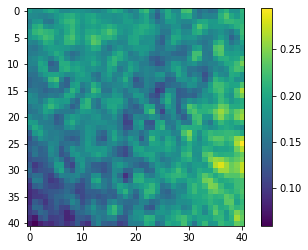

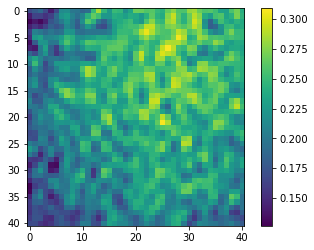

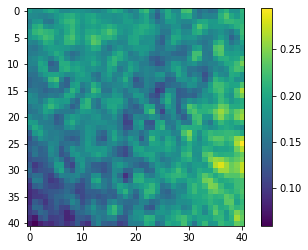

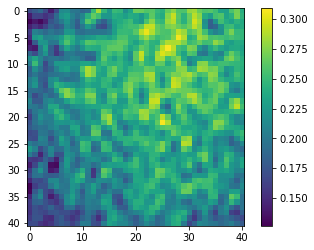

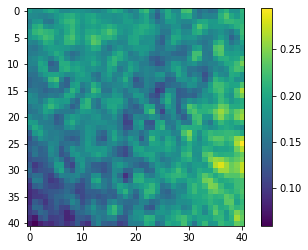

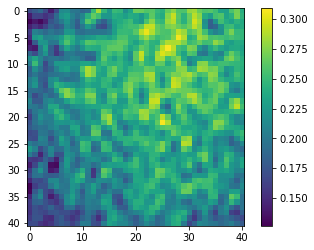

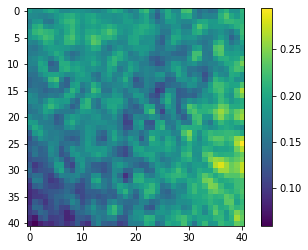

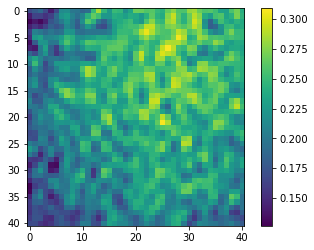

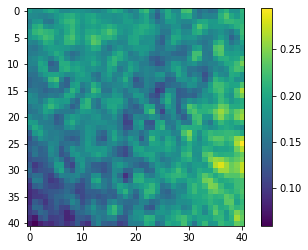

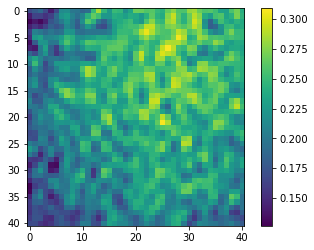

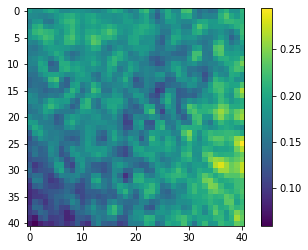

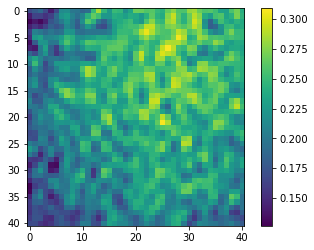

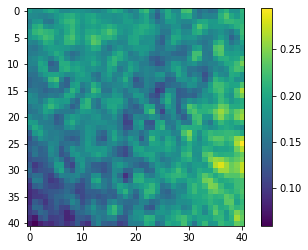

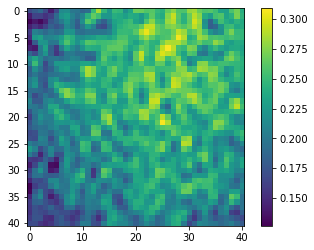

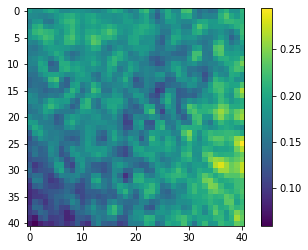

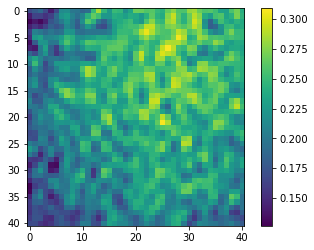

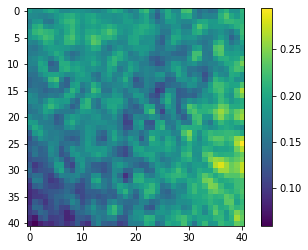

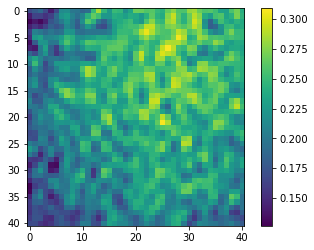

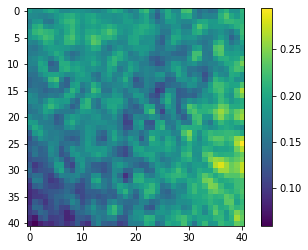

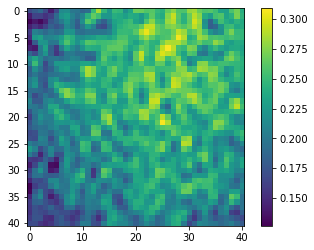

In [18]:
for i in range(10):
    plt.imshow(pos_im[0,...,0])
    plt.colorbar()
    plt.show()
    plt.close()
    
    plt.imshow(neg_im[0,...,0])
    plt.colorbar()
    plt.show()
    plt.close()

In [28]:
pos_im[0,...,0]

array([[176.7971  , 168.64992 , 184.56111 , ..., 182.73038 , 237.39532 ,
        240.00302 ],
       [198.09401 , 180.3943  , 184.79564 , ..., 204.94785 , 224.30109 ,
        216.41695 ],
       [204.78496 , 193.99733 , 173.48862 , ..., 220.48143 , 212.60477 ,
        198.51892 ],
       ...,
       [106.677124, 132.05486 , 146.90706 , ..., 272.72614 , 236.56758 ,
        225.65332 ],
       [121.23863 , 137.62193 , 137.63063 , ..., 290.27905 , 253.53911 ,
        220.09712 ],
       [136.26793 , 143.61432 , 150.96835 , ..., 265.76666 , 260.09656 ,
        218.64114 ]], dtype=float32)

# Wise Images

In [58]:
data_dir = '/project/r/rbond/jorlo/datasets/act_centered_wise_stamps/'

act_catalog = fits.open('/gpfs/fs0/project/r/rbond/jorlo/cluster_catalogs/DR5_cluster-catalog_v1.0b2.fits')

zs = np.array(act_catalog[1].data['redshift'])

In [59]:
pos_im = []
neg_im = []

z_cut = 0.0

#I made images centered on ACT and DES cluster locations (positives) as well as random points at least 5' 
#from a known cluster (negatives). This code just loads those
for file in os.listdir(data_dir):
    if file[:7] == 'cluster':
        j = int(str(file[-8:-4]).strip('0'))
        if zs[j] < z_cut: continue
        with np.load(data_dir + file) as data:
            pos_im.append(data['arr_0'])
    if file[:7] == 'randoms':
        with np.load(data_dir + file) as data:
            neg_im.append(data['arr_0'])


pos_im = np.array(pos_im)
neg_im = np.array(neg_im)

#cuts out any maps that have nans in them
flags = []
for i in range(pos_im.shape[0]):
        if np.any(np.isnan(pos_im[i,...])):
                flags.append(i)

pos_im = np.delete(pos_im, flags, axis = 0)

flags = []
for i in range(neg_im.shape[0]):
        if np.any(np.isnan(neg_im[i,...])):
                flags.append(i)

neg_im = np.delete(neg_im, flags, axis = 0)


hard_cuts = [500,  500, 2000, 4000]

flags = []
for j, im in enumerate(pos_im):
    for i in range(4):
        if np.any(im[...,i] > hard_cuts[i]):
            flags.append(j)
            break
pos_im = np.delete(pos_im, flags, axis = 0)

flags = []
for j, im in enumerate(neg_im):
    for i in range(4):
        if np.any(im[...,i] > hard_cuts[i]):
            flags.append(j)
            break
neg_im = np.delete(neg_im, flags, axis = 0)


#Force the positive and negative samples to have the same size
neg_im = neg_im[:len(pos_im)]
pos_im = pos_im[:len(neg_im)]

print(len(pos_im), len(neg_im))


1849 1849


In [60]:
#Mask vvv bright point sources

cuts = [100, 100, 99999, 999999]

for im in pos_im:
    for i in range(4):
        im[...,i][im[...,i] >= cuts[i]] = np.random.rand()
for im in neg_im:
    for i in range(4):
        im[...,i][im[...,i] >= cuts[i]] = np.random.rand()

In [61]:
norms = [30, 30, 300, 80]
for i in range(4):
    pos_im[..., i]/= norms[i]
    neg_im[..., i]/= norms[i]

In [62]:
reduce = None

if reduce:
    neg_im_2 = []
    pos_im_2 = []

    for i in range(len(neg_im)):
        neg_im_2.append(block_reduce(neg_im[i], [reduce,reduce,1], func = np.amax))
        pos_im_2.append(block_reduce(pos_im[i], [reduce,reduce,1], func = np.amax))
        

    pos_im = np.array(pos_im_2)
    neg_im = np.array(neg_im_2)


0


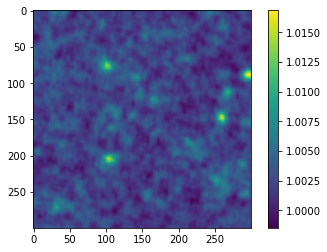

1


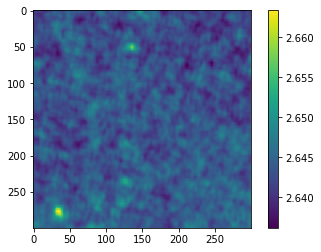

2


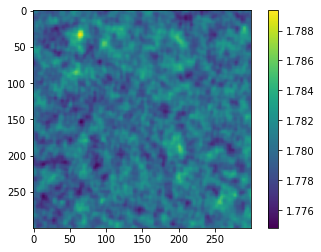

3


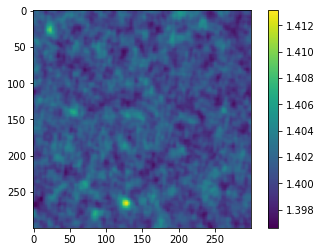

4


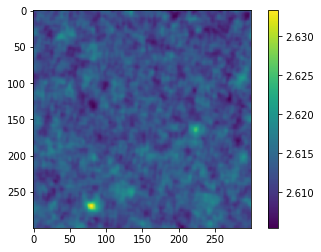

5


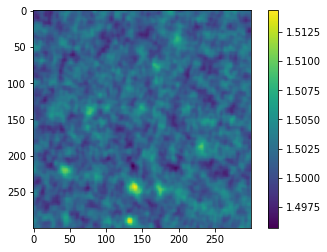

6


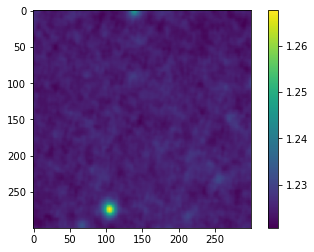

7


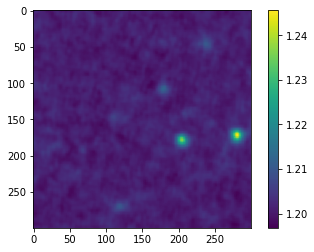

8


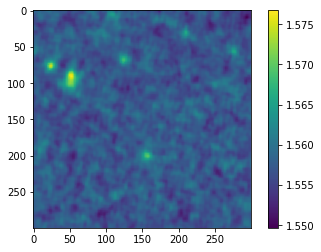

9


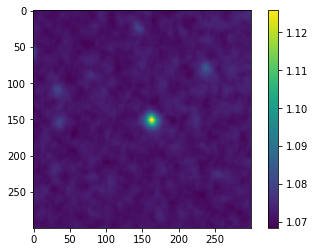

In [63]:
for i in range(10):
    print(i)
    plt.imshow(pos_im[i,...,2])#, vmin=0, vmax=1)
    plt.colorbar()
    plt.show()
    plt.close()

In [64]:
all_bands = False

if not all_bands:
    pos_im = pos_im[...,:2]
    neg_im = neg_im[...,:2]

In [65]:
print(pos_im.shape)

(1849, 300, 300, 2)


In [66]:
tot = min(pos_im.shape[0], neg_im.shape[0])
train_size = int(0.7 * tot)
val_size = int(0.15 * tot)
test_size = int(0.15 * tot)

train_pos = pos_im[:train_size]
val_pos = pos_im[train_size:train_size + val_size]
test_pos = pos_im[train_size + val_size:]

train_neg = neg_im[:train_size]
val_neg = neg_im[train_size:train_size + val_size]
test_neg = neg_im[train_size + val_size:]

input_shape = train_pos.shape[1:]

train_images = np.concatenate((train_pos,train_neg))
val_images = np.concatenate((val_pos,val_neg))
test_images = np.concatenate((test_pos,test_neg))

train_labels = np.array(train_pos.shape[0]*[1] + train_neg.shape[0]*[0])
val_labels = np.array(val_pos.shape[0]*[1] + val_neg.shape[0]*[0])
test_labels = np.array(test_pos.shape[0]*[1] + test_neg.shape[0]*[0])

#This just sets the # of samples we include in a trianing epoch, which is called the batch size. Autotune is a bit
#of magic that allows tf to dynamically set some hyperparameters in an optimal way. See https://www.tensorflow.org/guide/data_performance
batch_size = 500
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

#We shuffle our data (i.e. just mix up the order) and batch it
train_dataset = train_dataset.shuffle(buffer_size=128).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=128).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=128).batch(batch_size)

#Preloads data into memory
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
model = make_model('DeepShadows', input_shape = input_shape, kernel_regularizer=regularizers.l2(0.001))

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, width_shift_range=0.1,
    height_shift_range=0.1,zoom_range=0.3)


checkpoint_path = "/scratch/r/rbond/jorlo/ml-clusters/models/wise/jupyter_redmapper_wise_w1_w2.ckpt"

        
checkpoint_dir = os.path.dirname(checkpoint_path)

#A helper function for checkpointing
def get_callbacks(name):
    return [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1),
      tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100),
      tf.keras.callbacks.TensorBoard(checkpoint_dir+name),
    ]        

#model.load_weights('/scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_wise.ckpt')
# Create a callback that saves the model's weights

name = 'wise'

toc = time.time()
#Actually fits the model to the data. data_augmentation.flow generates augmented data sets from the data sets we pass it.
#Epochs sets the number of rounds of fitting to perform. 
history = model.fit(data_augmentation.flow(train_images, train_labels), epochs=int(100), 
                    validation_data=val_dataset, callbacks=get_callbacks(name))
tic = time.time()

print('Distributed time: ', tic-toc)

#Evaluate how well our model does
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 300, 300, 16)      304       
                                                                 
 batch_normalization_18 (Bat  (None, 300, 300, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 150, 150, 16)     0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 150, 150, 16)   

/home/r/rbond/jorlo/.conda/envs/ml-clusters/lib/python3.8/site-packages/keras_preprocessing/image/numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2588, 300, 300, 2) (2 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


Epoch 1/100
81/81 [==============================] - ETA: 0s - loss: 151.3420 - accuracy: 0.5170

2023-01-13 16:41:15.900601: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 14.26G (15310127104 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory



Epoch 1: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_wise_w1_w2.ckpt
81/81 [==============================] - 33s 402ms/step - loss: 151.3420 - accuracy: 0.5170 - val_loss: 83.8626 - val_accuracy: 0.5018
Epoch 2/100
81/81 [==============================] - ETA: 0s - loss: 53.5145 - accuracy: 0.5294
Epoch 2: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_wise_w1_w2.ckpt
81/81 [==============================] - 30s 369ms/step - loss: 53.5145 - accuracy: 0.5294 - val_loss: 31.1982 - val_accuracy: 0.5000
Epoch 3/100
81/81 [==============================] - ETA: 0s - loss: 20.2023 - accuracy: 0.5158
Epoch 3: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_wise_w1_w2.ckpt
81/81 [==============================] - 30s 370ms/step - loss: 20.2023 - accuracy: 0.5158 - val_loss: 13.1895 - val_accuracy: 0.5000
Epoch 4/100
81/81 [==============================] - ETA: 0s - loss: 9.2314 - accuracy: 0.5236
Epoch 

81/81 [==============================] - ETA: 0s - loss: 0.7465 - accuracy: 0.8130
Epoch 26: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_wise_w1_w2.ckpt
81/81 [==============================] - 30s 367ms/step - loss: 0.7465 - accuracy: 0.8130 - val_loss: 0.7321 - val_accuracy: 0.8141
Epoch 27/100
81/81 [==============================] - ETA: 0s - loss: 0.7342 - accuracy: 0.8114
Epoch 27: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_wise_w1_w2.ckpt
81/81 [==============================] - 30s 369ms/step - loss: 0.7342 - accuracy: 0.8114 - val_loss: 0.7829 - val_accuracy: 0.7798
Epoch 28/100
81/81 [==============================] - ETA: 0s - loss: 0.7168 - accuracy: 0.8176
Epoch 28: saving model to /scratch/r/rbond/jorlo/ml-clusters/models/jupyter_redmapper_wise_w1_w2.ckpt
81/81 [==============================] - 31s 379ms/step - loss: 0.7168 - accuracy: 0.8176 - val_loss: 0.6933 - val_accuracy: 0.8538
Epoch 29/100
81/81 [===

In [12]:
#Only save if good
model.save_weights('/scratch/r/rbond/jorlo/ml-clusters/models/wise/wise_w1_w2_w3_w4_dimitrios')